Copyright (C) 2021-2022, Intel Corporation

SPDX-License-Identifier: Apache-2.0

# Object detection with tiny YOLOv2 in Python using OpenVINO™ Execution Provider:

1. The Object detection sample uses a tinyYOLOv2 Deep Learning ONNX Model from the ONNX Model Zoo.


2. The sample involves presenting an Image to ONNX Runtime (RT), which uses the OpenVINO™ Execution Provider to run inference on various Intel hardware devices as mentioned before and perform object detection to detect up to 20 different objects like birds, buses, cars, people and much more.

The source code for this sample is available [here](https://github.com/microsoft/onnxruntime-inference-examples/tree/main/python/OpenVINO_EP/tiny_yolo_v2_object_detection).

### Install Requirements

In [ ]:
!pip -q install --upgrade pip
!pip -q install folium==0.2.1
!pip -q install imgaug==0.2.6
!pip -q install certifi==2022.5.18.1
!pip -q install flatbuffers==2.0
!pip -q install numpy==1.21.6
!pip -q install onnx==1.11.0
!pip -q install opencv-python==4.5.5.64
!pip -q install scipy==1.7.3
!pip -q install typing-extensions==4.1.1
!pip -q install onnxruntime-openvino==1.11.0

### Import Necessary Resources

In [ ]:
import numpy as np
import onnxruntime as rt
import cv2
import time
import os
from pathlib import Path
import argparse
import platform
from google.colab.patches import cv2_imshow
import sys

### Get the model and input

In [ ]:
#Create List of files in the directory
files = os.listdir('.')

#Get the neccesary files into the directory if they don't already exist
if ('tinyyolov2-8.onnx' not in files):
  !wget https://github.com/onnx/models/blob/main/vision/object_detection_segmentation/tiny-yolov2/model/tinyyolov2-8.onnx?raw=true -O tinyyolov2-8.onnx
if ('dog.bmp' not in files):
  !wget https://storage.openvinotoolkit.org/data/test_data/images/512x512/dog.bmp

## Preprocess

### Reshape the input to align with the model


When we are using a pre-trained model, which is trained & fine-tuned using a fixed image size as input, we should resize our image to a shape which is expected by the model. The image is re-shaped to the desired image size i.e. $(416 \times 416)$ using the `opencv` package. Here this is acheived by the `image_preprocess` helper function.


In [ ]:
def image_preprocess(frame):
  in_frame = cv2.resize(frame, (416, 416))
  preprocessed_image = np.asarray(in_frame)
  preprocessed_image = preprocessed_image.astype(np.float32)
  preprocessed_image = preprocessed_image.transpose(2,0,1)
  #Reshaping the input array to align with the input shape of the model
  preprocessed_image = preprocessed_image.reshape(1,3,416,416)
  return preprocessed_image

### Check file paths

`check_model_extention` is a helper function which checks if the model is present in the location specified. It also validates the model by checking the model file extension.  
The expected model file should be of `<model_name>.onnx` format.

In [ ]:
def check_model_extension(fp):
  # Split the extension from the path and normalise it to lowercase.
  ext = Path(fp).suffix.lower()

  # Now we can simply use != to check for inconsitencies with model file.
  if(ext != ".onnx"):
    raise NameError(fp, "is an unknown file format. Use the model ending with .onnx format")
  
  if not Path(fp).exists():
    raise OSError("[ ERROR ] Path of the onnx model file is Invalid")

## Postprocess

### Add the appropriate bounding boxes and the class label to the image based on the inference results

In [ ]:
def postprocess_output(out, frame, x_scale, y_scale):
  out = out[0][0]
  num_classes = 20
  anchors = [1.08, 1.19, 3.42, 4.41, 6.63, 11.38, 9.42, 5.11, 16.62, 10.52]
  
  # color look up table for different classes for object detection sample
  clut = [(0,0,0),(255,0,0),(255,0,255),(0,0,255),(0,255,0),(0,255,128),
        (128,255,0),(128,128,0),(0,128,255),(128,0,128),
        (255,0,128),(128,0,255),(255,128,128),(128,255,128),(255,255,0),
        (255,128,128),(128,128,255),(255,128,128),(128,255,128),(128,255,128)]

  # 20 labels that the tiny-yolov2 model can do the object_detection on
  label = ["aeroplane","bicycle","bird","boat","bottle",
            "bus","car","cat","chair","cow","diningtable",
            "dog","horse","motorbike","person","pottedplant",
            "sheep","sofa","train","tvmonitor"]

  existing_labels = {l: [] for l in label}

  #Inside this loop we compute the bounding box b for grid cell (cy, cx)
  for cy in range(0,13):
    for cx in range(0,13):
      for b in range(0,5):
      # First we read the tx, ty, width(tw), and height(th) for the bounding box from the out array, as well as the confidence score
        channel = b*(num_classes+5)
        tx = out[channel  ][cy][cx]
        ty = out[channel+1][cy][cx]
        tw = out[channel+2][cy][cx]
        th = out[channel+3][cy][cx]
        tc = out[channel+4][cy][cx]

        x = (float(cx) + sigmoid(tx))*32
        y = (float(cy) + sigmoid(ty))*32
        w = np.exp(tw) * 32 * anchors[2*b]
        h = np.exp(th) * 32 * anchors[2*b+1]

        #calculating the confidence score
        confidence = sigmoid(tc) # The confidence value for the bounding box is given by tc
        classes = np.zeros(num_classes)
        for c in range(0,num_classes):
          classes[c] = out[channel + 5 +c][cy][cx]
          # we take the softmax to turn the array into a probability distribution. And then we pick the class with the largest score as the winner.
          classes = softmax(classes)
          detected_class = classes.argmax()
          # Now we can compute the final score for this bounding box and we only want to keep the ones whose combined score is over a certain threshold
          if 0.75 < classes[detected_class]*confidence:
            color =clut[detected_class]
            x = (x - w/2)*x_scale
            y = (y - h/2)*y_scale
            w *= x_scale
            h *= y_scale
               
            labelX = int((x+x+w)/2)
            labelY = int((y+y+h)/2)
            addLabel = True
            lab_threshold = 100
            for point in existing_labels[label[detected_class]]:
              if labelX < point[0] + lab_threshold and labelX > point[0] - lab_threshold and \
                 labelY < point[1] + lab_threshold and labelY > point[1] - lab_threshold:
                 addLabel = False
            #Adding class labels to the output of the frame and also drawing a rectangular bounding box around the object detected.
            if addLabel:
              bbox_mess = f'{label[detected_class]}:{classes[detected_class]*confidence:.3f}'
              cv2.rectangle(frame, (int(x),int(y)),(int(x+w),int(y+h)),color,2)
              cv2.rectangle(frame, (int(x),int(y-13)),(int(x)+9*len(bbox_mess),int(y)),color,-1)
              cv2.putText(frame,bbox_mess,(int(x)+2,int(y)-3),cv2.FONT_HERSHEY_COMPLEX,0.4,(255,255,255),1)
              existing_labels[label[detected_class]].append((labelX,labelY))
              print(f'{label[detected_class]} detected in frame with {classes[detected_class]*confidence*100}% probability ')

### Show the image with the bounding boxes

In [ ]:
def show_bbox(device, frame, inference_time):
  cv2.putText(frame,device,(10,20),cv2.FONT_HERSHEY_COMPLEX,0.5,(255,255,255),1)
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  cv2_imshow(frame)

### sigmoid and softmax functions to make sense of infrence output for the model

In [ ]:
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

def softmax(x):
  score_mat_exp = np.exp(np.asarray(x))
  return score_mat_exp / score_mat_exp.sum(0)

## Inference

### Create a session for inference based on the device selected

Inferencing using OpenVINO Execution provider under ONNX-Runtime, is performed using the below simple steps:
    
1. Create a ONNX Runtime Session Option instance using `onnxruntime.SessionOptions()`
2. Using the session options instance create a Inference Session object by passing the model and the execution provider as arguments.
Execution Providers are the hardware device options e.g. CPU, Myriad, GPU, etc. on which the session will be executed.

The below `create_sess` function actually takes care of the above steps. All we need to do is pass the device arguement to it. It'll return the appropriate session according to the selected device along with the input name for the model.

The device option should be chosen from any one of the below options:  
- `cpu, CPU_FP32, GPU_FP32, GPU_FP16, MYRIAD_FP16, VADM_FP16`

In [ ]:
def create_sess(device):
  so = rt.SessionOptions()
  so.log_severity_level = 3
  if (device == 'cpu'):
    print("Device type selected is 'cpu' which is the default CPU Execution Provider (MLAS)")
    #Specify the path to the ONNX model on your machine and register the CPU EP
    sess = rt.InferenceSession(model, so, providers=['CPUExecutionProvider'])
  elif (device == 'CPU_FP32' or device == 'GPU_FP32' or device == 'GPU_FP16' or device == 'MYRIAD_FP16' or device == 'VADM_FP16'):
    #Specify the path to the ONNX model on your machine and register the OpenVINO EP
    sess = rt.InferenceSession(model, so, providers=['OpenVINOExecutionProvider'], provider_options=[{'device_type' : device}])
    print("Device type selected is: " + device + " using the OpenVINO Execution Provider")
    '''
    other 'device_type' options are: (Any hardware target can be assigned if you have the access to it)
    'CPU_FP32', 'GPU_FP32', 'GPU_FP16', 'MYRIAD_FP16', 'VAD-M_FP16'
    '''
  else:
    raise Exception("Device type selected is not [cpu, CPU_FP32, GPU_FP32, GPU_FP16, MYRIAD_FP16, VADM_FP16]")

  # Get the input name of the model
  input_name = sess.get_inputs()[0].name

  return sess, input_name

### Specify the device and path to model, Image

In [ ]:
model = "tinyyolov2-8.onnx"
image = "dog.bmp"

### Validate model file path

In [ ]:
check_model_extension(model)

### Setup input and output

In [ ]:
if (image):
    
    #Check if image file exists
    if not Path(image).is_file():
        raise OSError("Input image file ", image, " doesn't exist as a file")

    # Open the image file
    cap = cv2.imread(image)

    height, width, c = cap.shape
    x_scale = float(width)/416.0  #In the document of tino-yolo-v2, input shape of this network is (1,3,416,416).
    y_scale = float(height)/416.0

    output_file = Path(image).stem+'_tiny_yolov2_out_py.jpg'

### Run the inference with default CPU Execution Provider <a name="cpu_exec"></a>

Now the `tinyyolov2-8.onnx` model will run inference on `cat.jpg` image using the below two execution providers:
- `cpu`: default CPU Execution Provider (MLAS)  
- `CPU_FP32`: Execution on CPU with OpenVino Execution Provider

The below code block performs the following operations:

1. Creates a Onnx Runtime Session using `cpu` as device
2. Loads the input image and performs pre-processing using `image_preprocess` function
3. Performs prediction on the same image for $100$-times
4. Calculates average inference time
5. Performs post-processing, non-max suppression & bounding-box drawing using the predicted outputs from the model


Device type selected is 'cpu' which is the default CPU Execution Provider (MLAS)
PREDICTION - BEGIN
Avg Inference time in ms: 171.4293139199998
PREDICTION - END
dog detected in frame with 80.20803000214038% probability 


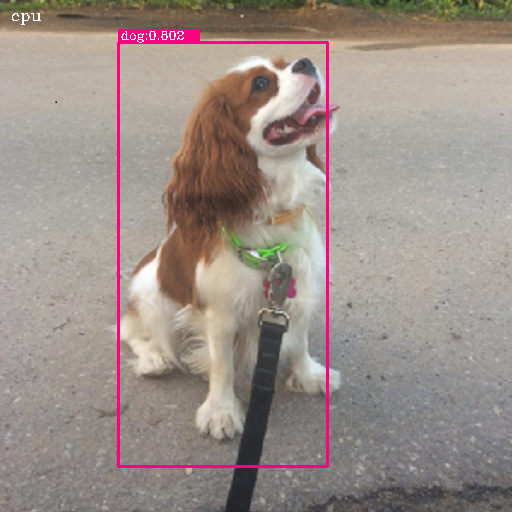

In [ ]:
### create a session with cpu which is the default CPU Execution Provider
sess, input_name = create_sess("cpu")

#capturing one frame at a time from the video feed and performing the inference
frame = cap.copy()

#preprocessing the input frame and reshaping it.
#In the document of tiny-yolo-v2, input shape of this network is (1,3,416,416). so we resize the model frame w.r.t that size.
preprocessed_image =  image_preprocess(frame)

print("PREDICTION - BEGIN")
#warmup
sess.run(None, {input_name: preprocessed_image})

start = time.perf_counter()
#Running the session by passing in the input data of the model
for i in range(100):
  out = sess.run(None, {input_name: preprocessed_image})

end = time.perf_counter()
inference_time = end - start
print(f'Avg Inference time in ms: {(inference_time/100 * 1000)}')
print("PREDICTION - END")

#Get the output
postprocess_output(out, frame, x_scale, y_scale)

#Show the output
show_bbox("cpu", frame, inference_time)

#Write the frame with the detection boxes
cv2.imwrite(output_file, frame.astype(np.uint8))
print('\n')

### Run the inference with OpenVINO Execution Provider
The below code block performs the same opertions as [before](#cpu_exec) with `CPU_FP32` as device, that runs on OpenVINO Execution Provider for ONNX Runtime.

Device type selected is: CPU_FP32 using the OpenVINO Execution Provider
PREDICTION - BEGIN
Avg Inference time in ms: 143.52424147999955
PREDICTION - END
dog detected in frame with 80.20795232381303% probability 


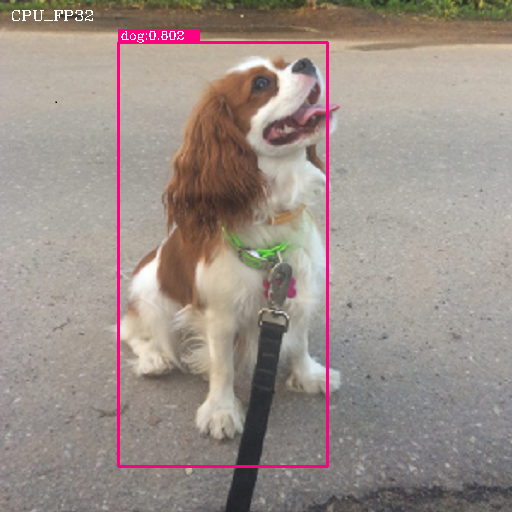

In [ ]:
### create a session with CPU_FP32 using the OpenVINO Execution Provider
sess, input_name = create_sess("CPU_FP32")

#capturing one frame at a time from the video feed and performing the inference
frame = cap.copy()

#preprocessing the input frame and reshaping it.
#In the document of tiny-yolo-v2, input shape of this network is (1,3,416,416). so we resize the model frame w.r.t that size.
preprocessed_image =  image_preprocess(frame)

print("PREDICTION - BEGIN")
#warmup
sess.run(None, {input_name: preprocessed_image})

start = time.perf_counter()
#Running the session by passing in the input data of the model
for i in range(100):
  out = sess.run(None, {input_name: preprocessed_image})

end = time.perf_counter()
inference_time = end - start
print(f'Avg Inference time in ms: {(inference_time/100 * 1000)}')
print("PREDICTION - END")

#Get the output
postprocess_output(out, frame, x_scale, y_scale)

#Show the output
show_bbox("CPU_FP32", frame, inference_time)

#Write the frame with the detection boxes
cv2.imwrite(output_file, frame.astype(np.uint8))
print('\n')